In [1]:
# path to our image folder
# For the first run, download the images from http://data.vicos.si/datasets/FIDS30/FIDS30.zip, and unzip them to your folder
#imagePath='D:/GoogleDrive/Uni/Master/1.Semester/Machine Learning/UE1/ML-fun/ex3/FIDS30/'
imagePath='FIDS30'

# Find all images in that folder; there are like 1.000 different ways to do this in Python, we chose this one :-)
import glob, os
os.chdir(imagePath)
fileNames = glob.glob("*/*.jpg")
numberOfFiles=len(fileNames)
targetLabels=[]

print('Found {} files\n'.format(numberOfFiles))

# The first step - create the ground truth (label assignment, target, ...) 
# For that, iterate over the files, and obtain the class label for each file
# Basically, the class name is in the full path name, so we simply use that
for fileName in fileNames:
    pathSepIndex = fileName.index("\\")
    targetLabels.append(fileName[:pathSepIndex])

# sk-learn can only handle labels in numeric format - we have them as strings though...
# Thus we use the LabelEncoder, which does a mapping to Integer numbers
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(targetLabels) # this basically finds all unique class names, and assigns them to the numbers

print("Found the following classes: " + str(list(le.classes_)))

# now we transform our labels to integers
target = le.transform(targetLabels); 
print("Transformed labels (first elements: " + str(target[0:150]))

# If we want to find again the label for an integer value, we can do something like this:
print(list(le.inverse_transform([0, 18, 1])))

print("... done label encoding")

Found 971 files

Found the following classes: ['acerolas', 'apples', 'apricots', 'avocados', 'bananas', 'blackberries', 'blueberries', 'cantaloupes', 'cherries', 'coconuts', 'figs', 'grapefruits', 'grapes', 'guava', 'kiwifruit', 'lemons', 'limes', 'mangos', 'olives', 'oranges', 'passionfruit', 'peaches', 'pears', 'pineapples', 'plums', 'pomegranates', 'raspberries', 'strawberries', 'tomatoes', 'watermelons']
Transformed labels (first elements: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4]
['acerolas', 'olives', 'apples']
... done label encoding


Showing demo feature extraction on image D:/GoogleDrive/Uni/Master/1.Semester/Machine Learning/UE1/ML-fun/ex3/FIDS30/acerolas\15.jpg


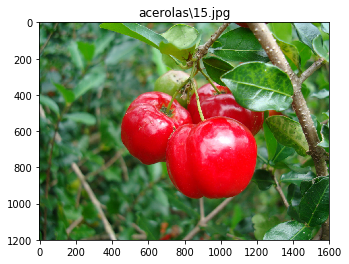

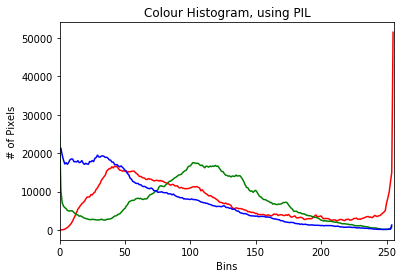

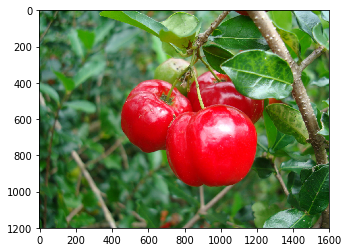

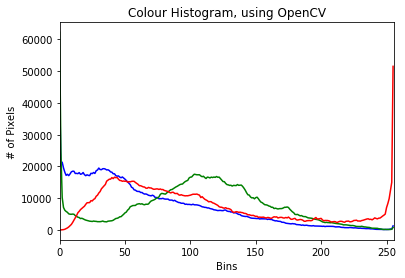

In [60]:
# Before we do actual feature extaction just for curiosity, let's look at one image, to illustrate what we are going to do

# import the necessary packages
from matplotlib import pyplot as plt

%matplotlib inline

# import libraries for image feature extraction
import numpy as np
import cv2
# For OpenCV (need Version 2.4+) for Python 2.7, on Ubuntu Linux, just "sudo apt install python-opencv"
# In other OS, that might be different.

from PIL import Image

demoImageName = fileNames[3]
demoImage = imagePath + demoImageName
print("Showing demo feature extraction on image " + demoImage)

# load the image & plot it
imagePIL = Image.open(demoImage)
imgplot = plt.imshow(imagePIL)
plt.title(demoImageName)

# now we compute a colour histogram using the histogram function in pillow
# This gives us one histogram with 768 values, which is 3 x 256 values for each colour
# For each colour channel, each value repesent the count how many pixels have that colour intensity
featureVector=imagePIL.histogram()

# We plot this histogram
plt.figure()
plt.plot(featureVector[:256], 'r')
plt.plot(featureVector[257:512], 'g')
plt.plot(featureVector[513:], 'b')
plt.xlim([0, 256])
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
plt.title("Colour Histogram, using PIL")

# An alternative is to use open CV
imageOpenCV = cv2.imread(demoImage)

# OpenCV is a bit weird, because it changes the channel order, it stores them as BGR, instead of RGB
# So if we want to display the image, we have to invert it
plt.figure()
plt.imshow(cv2.cvtColor(imageOpenCV, cv2.COLOR_BGR2RGB))

chans = cv2.split(imageOpenCV) # split the image in the different channels (RGB, but in open CV, it is BGR, actually..)
colors = ("b", "g", "r")
plt.figure()
plt.title("Colour Histogram, using OpenCV")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
featuresOpenCV = []

# loop over the image channels
for (chan, color) in zip(chans, colors):
    # create a histogram for the current channel and add it to the resulting histograms array (of arrays)
    # We can specifiy here in the 4th argument how many bins we want - 256 means the same as in the previous histogram
    histOpenCV = cv2.calcHist([chan], [0], None, [256], [0, 256])
    featuresOpenCV.extend(histOpenCV)

    # plot the histogram of the current colour
    plt.plot(histOpenCV, color = color)
    plt.xlim([0, 256])
    
# Now we have a 2D-array - 256 values for each of 3 colour channels.
# To input this into our machine learning, we need to "flatten" the features into one larger 1D array
# the size of this will be 3 x 256 = 768 values
featureVectorOpenCV = np.array(featuresOpenCV).flatten()


# show all the plots
plt.show()

In [63]:
# so NOW we actually extract features from our images
import datetime

print("Extracting features using PIL/PILLOW" + " (" + str(datetime.datetime.now()) + ")")

# The simplest approach is via the PIL/PILLOW package; here we get a histogram over each RGB channel
# Note: this doesn't really represent colours, as a colour is made up of the combination of the three channels!
data=[]
for index, fileName in enumerate(fileNames):
    imagePIL = Image.open(imagePath + fileName)
    # Not all images in our dataset are in RGB color scheme (e.g. indexed colours)
    # We need to make sure that they are RGB , otherwise we can't expect to have exactly three RGB channels..
    imagePIL = imagePIL.convert('RGB')     
    featureVector=imagePIL.histogram()
    
    if (len(featureVector) != 768): # just a sanity check; with the transformation to RGB, this should never happen
        print("Unexpected length of feature vector: " + str(len(featureVector)) + " in file: " + fileName)

    data.append((featureVector))

    
# Next, we extract a few more features using OpenCV

print("Extracting features using OpenCV" + " (" + str(datetime.datetime.now()) + ")")
dataOpenCV_1D=[]
dataOpenCV_2D=[]
dataOpenCV_3D=[]

# use our own simple function to flatten the 2D arrays
flatten = lambda l: [item for sublist in l for item in sublist]

for fileName in fileNames:

    # the easiest way would to do the following:
    # imageOpenCV = cv2.imread(imagePath + fileName)

    # However, we have the same issue as before, and it is more difficult in OpenCV to convert to an RGB image
    # Thus we do this using PIL, and then convert to OpenCV ....
    imagePIL = Image.open(imagePath + fileName)
    imagePIL = imagePIL.convert('RGB')
    imageOpenCV = np.array(imagePIL) 
    # Convert RGB to BGR 
    imageOpenCV = imageOpenCV[:, :, ::-1].copy() 

    # Now we split the image in the three channels, B / G / R
    chans = cv2.split(imageOpenCV)
    colors = ("b", "g", "r")

    # First we do also features per channel, but this time, we aggregate them into a smaller number of bins
    # I.e. we do not have 256 values per channel, but less
    featuresOpenCV_1D = []
    bins_1D=64
    for (chan, color) in zip(chans, colors): # we compute the histogram over each channel
        histOpenCV = cv2.calcHist([chan], [0], None, [bins_1D], [0, 256])
        featuresOpenCV_1D.extend(histOpenCV)
    featureVectorOpenCV_1D = flatten(featuresOpenCV_1D) # and append this to our feature vector
    
    dataOpenCV_1D.append(featureVectorOpenCV_1D) # now we append the feature vector to the dataset so far

    if (len(featureVectorOpenCV_1D) != bins_1D*3): # sanity check, in case we had a wrong number of channels...
        print("Unexpected length of feature vector: " + str(len(featureVectorOpenCV_1D)) + " in file: " + fileName)

    # Next - features that look at two channels at the same time
    # E.g. we look at when green and blue have both "high values"
    # We reduce the size of bins further, to not have a too long feature vector
    featuresOpenCV_2D = []
    bins2D=16
    # look at all combinations of channels (R & B, R & G, B & G)
    featuresOpenCV_2D.extend(cv2.calcHist([chans[1], chans[0]], [0, 1], None, [bins2D, bins2D], [0, 256, 0, 256]))
    featuresOpenCV_2D.extend(cv2.calcHist([chans[1], chans[2]], [0, 1], None, [bins2D, bins2D], [0, 256, 0, 256]))
    featuresOpenCV_2D.extend(cv2.calcHist([chans[0], chans[2]], [0, 1], None, [bins2D, bins2D], [0, 256, 0, 256]))
    # and add that to our dataset
    featureVectorOpenCV_2D = flatten(featuresOpenCV_2D)
    dataOpenCV_2D.append(featureVectorOpenCV_2D)

    # finally, we look at all three channels at the same time.
    # We further reduce our bin size, because otherwise, this would become very large...
    featuresOpenCV_3D = cv2.calcHist([imageOpenCV], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    # append to our dataset
    featureVectorOpenCV_3D = featuresOpenCV_3D.flatten()
    dataOpenCV_3D.append(featureVectorOpenCV_3D)

        
print(".... done" + " (" + str(datetime.datetime.now()) + ")")

Extracting features using PIL/PILLOW (2019-02-18 18:15:51.117693)
Extracting features using OpenCV (2019-02-18 18:16:23.228111)
.... done (2019-02-18 18:17:28.527110)


[797.0,
 897.0,
 1216.0,
 1534.0,
 2012.0,
 2438.0,
 2978.0,
 3239.0,
 3118.0,
 2871.0,
 2419.0,
 1946.0,
 1706.0,
 1524.0,
 1349.0,
 1192.0,
 1243.0,
 1165.0,
 1062.0,
 1032.0,
 884.0,
 805.0,
 705.0,
 643.0,
 650.0,
 643.0,
 671.0,
 675.0,
 644.0,
 537.0,
 448.0,
 348.0,
 280.0,
 274.0,
 238.0,
 207.0,
 224.0,
 214.0,
 207.0,
 204.0,
 202.0,
 214.0,
 203.0,
 210.0,
 217.0,
 224.0,
 224.0,
 231.0,
 239.0,
 266.0,
 322.0,
 297.0,
 329.0,
 351.0,
 416.0,
 417.0,
 518.0,
 634.0,
 732.0,
 959.0,
 1268.0,
 3037.0,
 6948.0,
 61903.0,
 1145.0,
 883.0,
 947.0,
 1088.0,
 1444.0,
 2065.0,
 2915.0,
 3532.0,
 3185.0,
 2735.0,
 2565.0,
 2184.0,
 1853.0,
 1666.0,
 1532.0,
 1464.0,
 1299.0,
 1171.0,
 1114.0,
 986.0,
 887.0,
 814.0,
 732.0,
 713.0,
 730.0,
 721.0,
 687.0,
 633.0,
 499.0,
 355.0,
 312.0,
 262.0,
 250.0,
 275.0,
 233.0,
 233.0,
 235.0,
 215.0,
 183.0,
 228.0,
 200.0,
 200.0,
 204.0,
 235.0,
 211.0,
 235.0,
 229.0,
 233.0,
 264.0,
 275.0,
 274.0,
 311.0,
 327.0,
 356.0,
 396.0,
 438.0,


In [64]:
# And now we finally classify 
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn import neighbors
from sklearn import linear_model
from sklearn import naive_bayes
from sklearn import tree
from sklearn import ensemble
from sklearn import svm

# these are our feature sets; we will use each of them individually to train classifiers
trainingSets = [data, dataOpenCV_1D, dataOpenCV_2D, dataOpenCV_3D]

# set up a number of classifiers
classifiers = [neighbors.KNeighborsClassifier(),
               naive_bayes.GaussianNB(), 
               tree.DecisionTreeClassifier(),
               ensemble.RandomForestClassifier(),
               svm.SVC(),
               svm.LinearSVC(),
              ]

# Now iterate over the datasets & classifiers, and train...

for index, train in enumerate(trainingSets):
    for classifier in classifiers:
        # do the classification here ....
        

SyntaxError: unexpected EOF while parsing (<ipython-input-64-6eb1158e909e>, line 30)